# Tweets analysis with K-Means clustering using NLTK

* Involves grouping tweets into 3 categories: ***Computer Science, Telecommunication*** and ***Electronic*** then performing K-Means clustering on the grouped tweets to observe how they behave.
* There are several ways of approaching the problem of grouping the tweets, the adapted approach uses the technique of creating a set of words that can be confidently classified as belonging to a particular category for each of the 3 classes. 
* So the tweets are each compared with the 3 sets and assigned a similarity score. There are 2 main techniques I considered for computing similarity score:
    1. Cosine Similarity : Cosine similarity is a metric used to measure how similar the documents are irrespective of their size. This would involve creating word vectors for the set of words and all the tweets then performing the cosine similarity. TFIDF (bag of words model) Vectorizer would be ideal for this.
    2. Jaccard Similarity : Jaccard similarity is defined as size of intersection divided by size of union of two sets. Jaccard similarity takes only unique set of words for each sentence/document while cosine similarity takes total length of the vectors. Jaccard similarity is good for cases where duplication does not matter, cosine similarity is good for cases where duplication matters while analyzing text similarity. => In our case, context matters more than duplication thus making Jaccard similarity the most appropriate method to use.
* After classifiying the tweets K-Means clustering comes in.


## Importing libraries

In [1]:
# !pip install tweepy
# !pip install spacy --user
# !python3 -m spacy download en_core_web_sm

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy
import csv
import os
import glob
import datetime
import pandas as pd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_similarity_score
%matplotlib inline
import logging
logging.captureWarnings(True)

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Access to Twitter’s API using Tweepy / Verifying credentials

Why is it beneficial to access Twitter API?

* Tweets are by nature short-form and contain diverse and relevant topics, so by using Twitter API you get the type, volume and ‘newness’ of data.
* Access to Twitter’s API can be acheived by Tweepy which is an open source package that allows you to bypass a lot of those low level details.

In [4]:
auth = tweepy.OAuthHandler('ilfVmhYf4DQPjs47LvGuGCk1l', '7RYn8vhws2RkHe3ZneYRlWmTuLmTdZ18kwaRQWSBnshI9C04UG')
auth.set_access_token('1331275341013331973-Xq6nyayTyQZTOzpXEMBvL1xi1n6aOS', 'mxT65H33YrWQkVjAlTOtQ8fh2FpQufEbwihpTRvRPmFzV')
api = tweepy.API(auth, wait_on_rate_limit=True)
public_tweets = api.home_timeline()
for tweet in public_tweets:
    print(tweet.text)

In [5]:
# get the user object for twitter
user = api.get_user('RaniaAbid10')
print(user.screen_name)

RaniaAbid10


## Collecting Twitter data 

In [ ]:
filename = 'Computer_science_dataset_'+(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv'
with open (filename, 'w', newline='',encoding="utf-8") as csvFile:
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['date', 'tweetId','name','tweet','created_at','location'])
    # using tweepy Cursor
    for tweet in tweepy.Cursor(api.search, q='computer science', lang = 'en', count=50).items():
    # writing a csv file
        tweets_encoded = tweet.text.encode('utf-8')
        tweets_decoded = tweets_encoded.decode('utf-8')
        csvWriter.writerow([datetime.datetime.now().strftime("%Y-%m-%d  %H:%M"), tweet.id, tweet.user.screen_name, tweets_decoded, tweet.created_at, tweet._json["user"]["location"]])

In [ ]:
filename = 'Telecommunication_dataset_'+(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv'
with open (filename, 'w', newline='',encoding="utf-8") as csvFile:
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['date', 'tweetId','name','tweet','created_at','location'])
    # using tweepy Cursor
    for tweet in tweepy.Cursor(api.search, q='telecommunication', lang = 'en', count=50).items():
    # writing a csv file
        tweets_encoded = tweet.text.encode('utf-8')
        tweets_decoded = tweets_encoded.decode('utf-8')
        csvWriter.writerow([datetime.datetime.now().strftime("%Y-%m-%d  %H:%M"), tweet.id, tweet.user.screen_name, tweets_decoded, tweet.created_at, tweet._json["user"]["location"]])

In [ ]:
filename = 'Electronic_dataset_'+(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv'
with open (filename, 'w', newline='',encoding="utf-8") as csvFile:
    csvWriter = csv.writer(csvFile)
    csvWriter.writerow(['date', 'tweetId','name','tweet','created_at','location'])
    # using tweepy Cursor
    for tweet in tweepy.Cursor(api.search, q='electronic', lang = 'en', count=50).items():
    # writing a csv file
        tweets_encoded = tweet.text.encode('utf-8')
        tweets_decoded = tweets_encoded.decode('utf-8')
        csvWriter.writerow([datetime.datetime.now().strftime("%Y-%m-%d  %H:%M"), tweet.id, tweet.user.screen_name, tweets_decoded, tweet.created_at, tweet._json["user"]["location"]])

## Merging collected datasets into one csv file

In [6]:
# load datasets
computer_science_df= pd.read_csv('Datasets_Example2/Computer_science_dataset_2020-12-15.csv')
telecommunication_df= pd.read_csv('Datasets_Example2/Telecommunication_dataset_2020-12-15.csv')
electronic_df= pd.read_csv('Datasets_Example2/Electronic_dataset_2020-12-15.csv')
# display the size of each dataset (rows and columns)
print('Computer science dataset size:', computer_science_df.shape)
print('Telecommunication dataset size:', telecommunication_df.shape)
print('Electronic dataset size:', electronic_df.shape)

Computer science dataset size: (3572, 6)
Telecommunication dataset size: (3405, 6)
Electronic dataset size: (3788, 6)


In [7]:
# concate 
os.chdir('Datasets_Example2')
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
# combine all files in the list
combined_csv = pd.concat(([pd.read_csv(f) for f in all_filenames]))
# export to csv
combined_csv.to_csv( "Collected_dataset.csv", index=False, encoding='utf-8')

## Cleaning data / Text preprocessing

* Text data can be sourced from difference places, it can be web scraped and it may also come from online documentation. Text preprocessing is essential in order to further manipulate your text data. In natural language processing, one thing to keep in mind is that whatever you do to the raw data may have an impact on how your model will be trained.
* NLTK is a suite of libraries which will help tokenize (break down) text into desired pieces of information (words and sentences). It also allows stemming and lemmatization (normalization techniques).

In [8]:
# load collected data
def load_data():
    data = pd.read_csv('Collected_dataset.csv')
    return data

In [9]:
# print a concise summary about the data
tweets_df = load_data()
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 6 columns):
date          10765 non-null object
tweetId       10765 non-null int64
name          10765 non-null object
tweet         10765 non-null object
created_at    10765 non-null object
location      7616 non-null object
dtypes: int64(1), object(5)
memory usage: 504.7+ KB


In [10]:
# return some first rows to take a look at the data
tweets_df.head()

,date,tweetId,name,tweet,created_at,location
0,2020-12-15 17:25,1338882701714223104,goodgrades002,Essay due\nPay assignment \nResearch paper \np...,2020-12-15 16:24:45,NaN
1,2020-12-15 17:25,1338882588694470658,tinaell61718881,RT @maturefinancier: They cant justify one of ...,2020-12-15 16:24:19,NaN
2,2020-12-15 17:25,1338882543219855364,apiitoor,RT @drayy09: Akua Saucy the way you dey talk a...,2020-12-15 16:24:08,"Madina, Ghana"
3,2020-12-15 17:25,1338882537528193025,SLPS_CCR,Did you know that @SLPS_INFO has over 20 Caree...,2020-12-15 16:24:06,NaN
4,2020-12-15 17:25,1338882498407895042,thequantumbot,RT @time8machine: Linear algebra provides conc...,2020-12-15 16:23:57,India


In [11]:
# data description
tweets_df['created_at'].describe()

count                   10765
unique                  10385
top       2020-12-14 15:48:11
freq                        4
Name: created_at, dtype: object

* day with highest number ***14th December 2020***

In [12]:
# extraction of needed columns from the dataframe
df = tweets_df[['tweetId', 'name', 'tweet']]
df.head()

,tweetId,name,tweet
0,1338882701714223104,goodgrades002,Essay due\nPay assignment \nResearch paper \np...
1,1338882588694470658,tinaell61718881,RT @maturefinancier: They cant justify one of ...
2,1338882543219855364,apiitoor,RT @drayy09: Akua Saucy the way you dey talk a...
3,1338882537528193025,SLPS_CCR,Did you know that @SLPS_INFO has over 20 Caree...
4,1338882498407895042,thequantumbot,RT @time8machine: Linear algebra provides conc...


#### 1. Remove punctuations

In [13]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [14]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

df['tweet_punct'] = df['tweet'].apply(lambda x: remove_punct(x))
df.head()

,tweetId,name,tweet,tweet_punct
0,1338882701714223104,goodgrades002,Essay due\nPay assignment \nResearch paper \np...,Essay due\nPay assignment \nResearch paper \np...
1,1338882588694470658,tinaell61718881,RT @maturefinancier: They cant justify one of ...,RT maturefinancier They cant justify one of th...
2,1338882543219855364,apiitoor,RT @drayy09: Akua Saucy the way you dey talk a...,RT drayy Akua Saucy the way you dey talk about...
3,1338882537528193025,SLPS_CCR,Did you know that @SLPS_INFO has over 20 Caree...,Did you know that SLPSINFO has over Career an...
4,1338882498407895042,thequantumbot,RT @time8machine: Linear algebra provides conc...,RT timemachine Linear algebra provides concept...


#### 2. Tokenization

> The meaning of tokenization is to chop up some existing text into smaller chunks. For example, a paragraph can be tokenized into sentences and further into words.

In [15]:
def tokenization(text):
    text = re.split(' ', text)
    return text

df['tweet_tokenized'] = df['tweet_punct'].apply(lambda x: tokenization(x.lower()))
df.head()

,tweetId,name,tweet,tweet_punct,tweet_tokenized
0,1338882701714223104,goodgrades002,Essay due\nPay assignment \nResearch paper \np...,Essay due\nPay assignment \nResearch paper \np...,"[essay, due\npay, assignment, \nresearch, pape..."
1,1338882588694470658,tinaell61718881,RT @maturefinancier: They cant justify one of ...,RT maturefinancier They cant justify one of th...,"[rt, maturefinancier, they, cant, justify, one..."
2,1338882543219855364,apiitoor,RT @drayy09: Akua Saucy the way you dey talk a...,RT drayy Akua Saucy the way you dey talk about...,"[rt, drayy, akua, saucy, the, way, you, dey, t..."
3,1338882537528193025,SLPS_CCR,Did you know that @SLPS_INFO has over 20 Caree...,Did you know that SLPSINFO has over Career an...,"[did, you, know, that, slpsinfo, has, over, , ..."
4,1338882498407895042,thequantumbot,RT @time8machine: Linear algebra provides conc...,RT timemachine Linear algebra provides concept...,"[rt, timemachine, linear, algebra, provides, c..."


#### 3. Remove stopwords with the NLTK module

In [16]:
stopword = nltk.corpus.stopwords.words('english')

In [17]:
print(stopwords)

<WordListCorpusReader in 'C:\\Users\\ASUS\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [18]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
df['tweet_nonstop'] = df['tweet_tokenized'].apply(lambda x: remove_stopwords(x))
df.head()

,tweetId,name,tweet,tweet_punct,tweet_tokenized,tweet_nonstop
0,1338882701714223104,goodgrades002,Essay due\nPay assignment \nResearch paper \np...,Essay due\nPay assignment \nResearch paper \np...,"[essay, due\npay, assignment, \nresearch, pape...","[essay, due\npay, assignment, \nresearch, pape..."
1,1338882588694470658,tinaell61718881,RT @maturefinancier: They cant justify one of ...,RT maturefinancier They cant justify one of th...,"[rt, maturefinancier, they, cant, justify, one...","[rt, maturefinancier, cant, justify, one, lock..."
2,1338882543219855364,apiitoor,RT @drayy09: Akua Saucy the way you dey talk a...,RT drayy Akua Saucy the way you dey talk about...,"[rt, drayy, akua, saucy, the, way, you, dey, t...","[rt, drayy, akua, saucy, way, dey, talk, iphon..."
3,1338882537528193025,SLPS_CCR,Did you know that @SLPS_INFO has over 20 Caree...,Did you know that SLPSINFO has over Career an...,"[did, you, know, that, slpsinfo, has, over, , ...","[know, slpsinfo, , career, technical, educatio..."
4,1338882498407895042,thequantumbot,RT @time8machine: Linear algebra provides conc...,RT timemachine Linear algebra provides concept...,"[rt, timemachine, linear, algebra, provides, c...","[rt, timemachine, linear, algebra, provides, c..."


#### 4. Stemming

Stemming is used to normalize parts of text data. What does this mean exactly?
> When you are using a verb which is conjugated in multiple tenses throughout a document you would like to process, stemming will shorten all of these conjugated verbs to the shortest length of characters possible, it will preserve the root of the verb in this case. Stemming is done for all types of words and adjectives.

In [19]:
ps = nltk.PorterStemmer()
def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

df['tweet_stemmed'] = df['tweet_nonstop'].apply(lambda x: stemming(x))
df.head()

,tweetId,name,tweet,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed
0,1338882701714223104,goodgrades002,Essay due\nPay assignment \nResearch paper \np...,Essay due\nPay assignment \nResearch paper \np...,"[essay, due\npay, assignment, \nresearch, pape...","[essay, due\npay, assignment, \nresearch, pape...","[essay, due\npay, assign, \nresearch, paper, \..."
1,1338882588694470658,tinaell61718881,RT @maturefinancier: They cant justify one of ...,RT maturefinancier They cant justify one of th...,"[rt, maturefinancier, they, cant, justify, one...","[rt, maturefinancier, cant, justify, one, lock...","[rt, maturefinanci, cant, justifi, one, lockup..."
2,1338882543219855364,apiitoor,RT @drayy09: Akua Saucy the way you dey talk a...,RT drayy Akua Saucy the way you dey talk about...,"[rt, drayy, akua, saucy, the, way, you, dey, t...","[rt, drayy, akua, saucy, way, dey, talk, iphon...","[rt, drayi, akua, sauci, way, dey, talk, iphon..."
3,1338882537528193025,SLPS_CCR,Did you know that @SLPS_INFO has over 20 Caree...,Did you know that SLPSINFO has over Career an...,"[did, you, know, that, slpsinfo, has, over, , ...","[know, slpsinfo, , career, technical, educatio...","[know, slpsinfo, , career, technic, educ, prog..."
4,1338882498407895042,thequantumbot,RT @time8machine: Linear algebra provides conc...,RT timemachine Linear algebra provides concept...,"[rt, timemachine, linear, algebra, provides, c...","[rt, timemachine, linear, algebra, provides, c...","[rt, timemachin, linear, algebra, provid, conc..."


#### 5. Lemmatization

> Lemmatization is another normalization technique which is used in Natural Language Processing. The difference between stemming and lemmatization is that lemmatization will enable for words which do not have the same root to be grouped together in order for them to be processed as one item.

In [20]:
wn = nltk.WordNetLemmatizer()
def lemmatizer(text):
    text = [wn.lemmatize(word) for word in text]
    return text

df['tweet_lemmatized'] = df['tweet_nonstop'].apply(lambda x: lemmatizer(x))
df.head()

,tweetId,name,tweet,tweet_punct,tweet_tokenized,tweet_nonstop,tweet_stemmed,tweet_lemmatized
0,1338882701714223104,goodgrades002,Essay due\nPay assignment \nResearch paper \np...,Essay due\nPay assignment \nResearch paper \np...,"[essay, due\npay, assignment, \nresearch, pape...","[essay, due\npay, assignment, \nresearch, pape...","[essay, due\npay, assign, \nresearch, paper, \...","[essay, due\npay, assignment, \nresearch, pape..."
1,1338882588694470658,tinaell61718881,RT @maturefinancier: They cant justify one of ...,RT maturefinancier They cant justify one of th...,"[rt, maturefinancier, they, cant, justify, one...","[rt, maturefinancier, cant, justify, one, lock...","[rt, maturefinanci, cant, justifi, one, lockup...","[rt, maturefinancier, cant, justify, one, lock..."
2,1338882543219855364,apiitoor,RT @drayy09: Akua Saucy the way you dey talk a...,RT drayy Akua Saucy the way you dey talk about...,"[rt, drayy, akua, saucy, the, way, you, dey, t...","[rt, drayy, akua, saucy, way, dey, talk, iphon...","[rt, drayi, akua, sauci, way, dey, talk, iphon...","[rt, drayy, akua, saucy, way, dey, talk, iphon..."
3,1338882537528193025,SLPS_CCR,Did you know that @SLPS_INFO has over 20 Caree...,Did you know that SLPSINFO has over Career an...,"[did, you, know, that, slpsinfo, has, over, , ...","[know, slpsinfo, , career, technical, educatio...","[know, slpsinfo, , career, technic, educ, prog...","[know, slpsinfo, , career, technical, educatio..."
4,1338882498407895042,thequantumbot,RT @time8machine: Linear algebra provides conc...,RT timemachine Linear algebra provides concept...,"[rt, timemachine, linear, algebra, provides, c...","[rt, timemachine, linear, algebra, provides, c...","[rt, timemachin, linear, algebra, provid, conc...","[rt, timemachine, linear, algebra, provides, c..."


## Saving extracted cleaned data 

In [21]:
extracted_df = pd.DataFrame(df[['tweetId', 'name', 'tweet_lemmatized']])
extracted_df.head()

,tweetId,name,tweet_lemmatized
0,1338882701714223104,goodgrades002,"[essay, due\npay, assignment, \nresearch, pape..."
1,1338882588694470658,tinaell61718881,"[rt, maturefinancier, cant, justify, one, lock..."
2,1338882543219855364,apiitoor,"[rt, drayy, akua, saucy, way, dey, talk, iphon..."
3,1338882537528193025,SLPS_CCR,"[know, slpsinfo, , career, technical, educatio..."
4,1338882498407895042,thequantumbot,"[rt, timemachine, linear, algebra, provides, c..."


In [22]:
extracted_df.to_csv('Cleaned_data.csv', index = False, header = True)

In [23]:
# dataset verification
new_tweet_df= pd.read_csv('Cleaned_data.csv')
print('Dataset size:',new_tweet_df.shape)
print('Columns are:',new_tweet_df.columns)
new_tweet_df.info()
new_tweet_df.head()

Dataset size: (10765, 3)
Columns are: Index(['tweetId', 'name', 'tweet_lemmatized'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10765 entries, 0 to 10764
Data columns (total 3 columns):
tweetId             10765 non-null int64
name                10765 non-null object
tweet_lemmatized    10765 non-null object
dtypes: int64(1), object(2)
memory usage: 252.4+ KB


,tweetId,name,tweet_lemmatized
0,1338882701714223104,goodgrades002,"['essay', 'due\npay', 'assignment', '\nresearc..."
1,1338882588694470658,tinaell61718881,"['rt', 'maturefinancier', 'cant', 'justify', '..."
2,1338882543219855364,apiitoor,"['rt', 'drayy', 'akua', 'saucy', 'way', 'dey',..."
3,1338882537528193025,SLPS_CCR,"['know', 'slpsinfo', '', 'career', 'technical'..."
4,1338882498407895042,thequantumbot,"['rt', 'timemachine', 'linear', 'algebra', 'pr..."


## Defining the sets of words

In [24]:
computer_science_related_words = '''computer computation computing software algorithm hardware processor tested digital logic code information computer science CPU security system mainframe technology architecture interface survey surveyed experience improve improvement capability service link engineering program platform computationalsecurity virtual machine VM revolution approved softmodem telnet importance test minicomputer pseudocode new technologies supercomputer microprocessor screensaver pixel cyberintrusion information connection connectivity processing system microcomputer computing device computing machine data processor precomputer development cyber innovation IOT social networks communities data flow techie cybernetic computerology cybersystem computer-aid design computerist cybertechnology neurocomputer computerbased cyberinteraction network multinetworked multinetwork antivirus computerologist wardialer nanocomputer noncomputer business management downloader login logout uploader cybernetwork computerdom computerism compy virtualize bios ibook hack computable programmable telecommuter core computerize institutions values cyberterrorism incrementor  utility program PDA telecomputer computerlike computercide intranet cybersuicide configuration section central process unit download upgrade streaming manager database management rootkit command line interpreter cybergeneration digital communication data process data converter word process cyberfuture organize information web server install uninstall graphician machine code terminal access internet extranet turing machine teleinstruction graphic card open source stream video background process meatware scancode word processor killer poke memory chip sneakernet brain process information expansion slot surf internet at internet tv keyboard escape key computer graphic artificial intelligence computer visual display unit alpha test video card information superhighway data path etransaction technical information cybernetics programming language computational complexity theory informatics artificial intelligence  cace interoperability access computational IBM compiler debug assembler parser computer simulation computers programs technologies interactive organise encode computer engineering numerical analysis architecture prompt port disc foreground descriptor object firewall panel drive pointer ip counter document ontology risc video email track server package bbs bpi backup buffer argument filename parameter host address accumulator reference desktop background menu ascii dump microcode directory router register printer ram rom simulation node disk machine window spyware malware programmer eprom subdirectory CPU positioner cisc dongle e-mail submenu research laptop nonprogramming cyber machinima scientific systems lab tool predictor imac developed digital mac arithmometer business cyberpunk creative based tools AI technical science partnership department knowledge software engineer developer quality for everyone analysis natural  language processing cryptography mining progress progressing vision google microsoft apple facebook messenger amazon investment personal information editor resource applications calculator web system tech data labs work educational focuses internet communication multimedia sciences design focused expert bloatware using new modern secure online offline multitask technological multiprogramming concepts counterprogramming harvard instance misclick researchers graduate expertise innovative teleprogramming informatic innovation scientist device sophisticated experimental optimizer teleprogrammed subprogram cybernate multiload computer scientist web descktop computational problem mouseclick preprogram groupware processmaker computer graphics bitness phone mobile cyber programming language theory cyberdating fileserver computer programming deep learning modeling IoT java R C python SQL SPARQ html CSS UML merise framework iphone Samsung'''

In [25]:
telecommunication_related_words = '''telecommunication telephone phone mobile communication telecom wireless telephony telegraph telegraphy connect connection link smartpone line communications infrastructure radio internet optical fiber transmission call teleprinter duplex radiotelephone broadcasting cellphon intercommunication telecoms teletype services mobile broadband providers sectors operators telecommunications networks cellular session active activate satellite international telecommunication union teleoperator orange SFR bouygues gelgacom connectivity dial tone ECC transmission handset cellular telephone gsm voip asynchronous transfer mode noise signalling signal telephones interconnection wire emission information electromagnetic social socialized communities local area network entities sampling heliograph medium multiplex simplex iphone quantize telephonic telecommunicate phone smartphone propagation megaphone speaker miscommunication modem dataphone cybercommunication webphone systems electrocommunication webcam cellevision corp selfridges netphone allophone phonetic radio regulations BTS LTD navigation technology incommunicable radiotelegraph technologies communicative communicational electrical untelephoned speakerphone convention ict magnetotelephone telephoner operating phoneless unphoned autodialer telegraphic upgrading sector telephonable overcommunication networking teletex communication channel communicate shielded cable grid manufactures telkom textphone operator electromagnetic radiation phonable terminals integrated subsidiaries monopoly operates multimedia signal access automated trimphone satelite cable phoner telepathize monopolies system siemens contact conglomerate callback ethernet switchboard telegram poldhu telecommunication network liaison contacts communicator transmission receiver fiber-optic communication nyquist frequency communications satellite gain error rate frequency nyquist dial wireless communication etisalat zain interconnect modems audiovisual nilesat hotbird intelsat cabling antenna transmit transmitter uncommunicated kilowatt miscommunicate remote access LTD pocketphone italophone multiplexing state-owned telefelony voice mail unicom telephone system communication device router attenuation keyphone carrier wave germanophone telematic radiolocation fiberoptics radiocommunication digitalization upcall telephone receiver mobile telephone infrared downcall code radiogram telegraph cable channel mobile phone make call telephone operator ecommunication nanowatt dial telephone mhz hz bandwidth frequency wireless telegraphy modulation telegraph signals box telegraph bluetooth utility  tesla Samsung Apple Nokia Huawei Oppo call box call originator address message disk television make phone call network broadcasting corporation inscribe email wireless operator call in dial phone telephone mainframe symetric asymetric cellular phone dial switching request comment switch access point telephone box transmission control protocol Messenger WhatsApp call sign propaganda token ring visual communication telephone tag communication system radio station power amplifier send message messenger whatsapp channel social media fibre optic cable fiber optics fiber optic cable optical fibre telecommunication equipment subscriber line phone service fibre optics exchange idea electrical device data center telephone line call radio receiver exchange information microphone FTTX FTTH Huawei Cisco ADSL WIFI ethernet'''

In [26]:
electronic_related_words = '''digital analog computer electrical wireless portable electronic engineer engineering virtual device electromechanical interactive audio information hardware electric communication machine compnents devices systems electronically technology audiovisual computerization machines instruments sensors data multimedia equipment processing tool uses rapid tools scanning standard allows components use embedded manufacturers materials system editing phones enables users decoder development instrument installation application machine recording consumer commercial communication computerised micro phone cellphone communications technologies screen electro cybernetics electrician electrotechnical encrypted electricity kinetic energy power radiant amp energy heat chemical energy force joule vigor potential energy thermal energy heat engine entropy fuel mechanical energy efficiency vim activation energy physical phenomenon heating qi energy level focused new goals renewable energy biomass radiation conservation of energy alternative energy geothermal energy watt nuclear fission gas machinima taser telnet real-time transistor oscilloscope autodialer cyborg portability bios processor board electricity pda cpu electrode transmitter mac microprocessor electrify cyberinteraction netlag elektronik electrical device electrocommunication computerology electronic device third screen computer hardware radio frequency equipment biometric identification cathode information stream  information matrix printer automated authentication explosive detection system global positioning system thermometer security system personal digital robots robot best brain circuit sustainable distribute power AI supply error machine data center alternate current analog remote control electromagnetic pulse graphic card machine data process computer science test virtual reality technical support download manager visual display unit surf electronic electro mechanical frequency identification rfid devices digitized tamper proof auditable contactless biometrics  tags CD DVD hitech touchscreen wireless implementation implement implantable laptop computers texas instruments VHDL ARDUINO Matlab Simulink C python R DOS cables industry ASUS HP Lenovo Apple NVIDIA Intel Sun microsystems AMD Emerson DELL Sony Audit Renault BMW FIAT motor using artificial intellegence AI inttelligent smart work standard IEEE'''

## Preprocessing the sets

#### 1. Tokenizing, Lemmatizing and removing stopwords from the sets

In [27]:
nlp = en_core_web_sm.load()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
w_tokenizer = WhitespaceTokenizer()

# clean the set of words         
def furnished(text):
    final_text = []
    for i in text.split():
        if i.lower() not in stop:
            word = lemmatizer.lemmatize(i)
            final_text.append(word.lower())
    return " ".join(final_text)

computer_science = furnished(computer_science_related_words)
telecommunication = furnished(telecommunication_related_words)
electronic = furnished(electronic_related_words)

#### 2. deleting duplicates

In [28]:
string1 = computer_science
words = string1.split()
computer_science = " ".join(sorted(set(words), key=words.index))
computer_science

'computer computation computing software algorithm hardware processor tested digital logic code information science cpu security system mainframe technology architecture interface survey surveyed experience improve improvement capability service link engineering program platform computationalsecurity virtual machine vm revolution approved softmodem telnet importance test minicomputer pseudocode new supercomputer microprocessor screensaver pixel cyberintrusion connection connectivity processing microcomputer device data precomputer development cyber innovation iot social network community flow techie cybernetic computerology cybersystem computer-aid design computerist cybertechnology neurocomputer computerbased cyberinteraction multinetworked multinetwork antivirus computerologist wardialer nanocomputer noncomputer business management downloader login logout uploader cybernetwork computerdom computerism compy virtualize bios ibook hack computable programmable telecommuter core computeri

In [29]:
string2 = telecommunication
words = string2.split()
telecommunication = " ".join(sorted(set(words), key=words.index))
telecommunication

'telecommunication telephone phone mobile communication telecom wireless telephony telegraph telegraphy connect connection link smartpone line infrastructure radio internet optical fiber transmission call teleprinter duplex radiotelephone broadcasting cellphon intercommunication teletype service broadband provider sector operator network cellular session active activate satellite international union teleoperator orange sfr bouygues gelgacom connectivity dial tone ecc handset gsm voip asynchronous transfer mode noise signalling signal interconnection wire emission information electromagnetic social socialized community local area entity sampling heliograph medium multiplex simplex iphone quantize telephonic telecommunicate smartphone propagation megaphone speaker miscommunication modem dataphone cybercommunication webphone system electrocommunication webcam cellevision corp selfridges netphone allophone phonetic regulation bts ltd navigation technology incommunicable radiotelegraph comm

In [30]:
string3 = electronic
words = string3.split()
electronic = " ".join(sorted(set(words), key=words.index))
electronic

'digital analog computer electrical wireless portable electronic engineer engineering virtual device electromechanical interactive audio information hardware electric communication machine compnents system electronically technology audiovisual computerization instrument sensor data multimedia equipment processing tool us rapid scanning standard allows component use embedded manufacturer material editing phone enables user decoder development installation application recording consumer commercial computerised micro cellphone screen electro cybernetics electrician electrotechnical encrypted electricity kinetic energy power radiant amp heat chemical force joule vigor potential thermal engine entropy fuel mechanical efficiency vim activation physical phenomenon heating qi level focused new goal renewable biomass radiation conservation alternative geothermal watt nuclear fission gas machinima taser telnet real-time transistor oscilloscope autodialer cyborg portability bios processor board p

## Cosine Similarity

#### Vectorizing and Standadization

* After cleaning the sets, the next step is vectorising and standardizing them. 
  This is necessary to calculate Cosine Similarity score which is a measure of similarity between two groups (non-zero vectors). Implementing TF-IDF scheme would be perfect for that. 
* The idea behind TF-IDF approach is that the words that are more common in one sentence and less common in other sentences should be given high weights.

> The term TF stands for **"Term Frequency"** while the term IDF stands for the **"Inverse Document Frequency"**.

> **TF** = (Frequency of the word in the sentence) / (Total number of words in the sentence).

> **IDF** = (Total number of sentences (document))/(Number of sentences (document) containing the word)

In [31]:
# vectorizing the sets
def get_vectors(*strs):
    text = [t for t in strs]
    # create TfidfVectorizer object
    vectorizer = TfidfVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

computer_science_vector = get_vectors(computer_science)
telecommunication_vector = get_vectors(telecommunication)
electronic_vector = get_vectors(electronic)

In [32]:
# vectorizing the tweets
tv=TfidfVectorizer()
tfidf_tweets =tv.fit_transform(new_tweet_df.tweet_lemmatized)

## Jaccard Similarity

* The Jaccard similarity index measures the similarity between two sets of data. It can range from 0 to 1. 
  The higher the number, the more similar the two sets of data.
* Jaccard similarity is good for cases where duplication does not matter, cosine similarity is good for cases where duplication matters while analyzing text similarity. In our case, it would be better to use Jaccard similarity as repetition of a word does not reduce their similarity.
* The Jaccard similarity index is calculated as :

> **Jaccard Similarity** = (number of observations in both sets) / (number in either set).

In [33]:
# define Jaccard Similarity function
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [34]:
# define a Scores fuction to find Jaccard Similarity between the two defined sets 
def get_scores(group,tweets):
    scores = []
    for tweet in tweets:
        s = jaccard_similarity(group, tweet)
        scores.append(s)
    return scores

In [35]:
# computer science scores 
cs_scores = get_scores(computer_science, new_tweet_df.tweet_lemmatized.to_list())
cs_scores[-10:]

[0.6764705882352942,
 0.71875,
 0.6060606060606061,
 0.696969696969697,
 0.7272727272727273,
 0.7058823529411765,
 0.5151515151515151,
 0.6666666666666666,
 0.7272727272727273,
 0.696969696969697]

In [36]:
# telecommunication scores
t_scores = get_scores(telecommunication, new_tweet_df.tweet_lemmatized.to_list())
t_scores[-10:]

[0.696969696969697,
 0.7419354838709677,
 0.5757575757575758,
 0.6666666666666666,
 0.696969696969697,
 0.6764705882352942,
 0.53125,
 0.6363636363636364,
 0.75,
 0.71875]

In [37]:
# electronic scores
e_scores = get_scores(electronic, new_tweet_df.tweet_lemmatized.to_list())
e_scores[-10:]

[0.6764705882352942,
 0.71875,
 0.6060606060606061,
 0.696969696969697,
 0.7272727272727273,
 0.7058823529411765,
 0.5151515151515151,
 0.6666666666666666,
 0.7272727272727273,
 0.696969696969697]

In [38]:
# automation scores
#a_scores = get_scores(automation, new_tweet_df.tweet_lemmatized.to_list())
#a_scores[-10:]

**Defining a new dataframe containing names, and the jaccard scores for each group.**

In [39]:
data  = {'tweet':new_tweet_df.tweet_lemmatized.to_list(), 'computer_science_score': cs_scores,
         'telecommunication_score':t_scores, 'electronic_score':e_scores}
scores_df = pd.DataFrame(data)
scores_df.head()

,tweet,computer_science_score,telecommunication_score,electronic_score
0,"['essay', 'due\npay', 'assignment', '\nresearc...",0.617647,0.636364,0.617647
1,"['rt', 'maturefinancier', 'cant', 'justify', '...",0.606061,0.575758,0.606061
2,"['rt', 'drayy', 'akua', 'saucy', 'way', 'dey',...",0.555556,0.571429,0.555556
3,"['know', 'slpsinfo', '', 'career', 'technical'...",0.696970,0.718750,0.696970
4,"['rt', 'timemachine', 'linear', 'algebra', 'pr...",0.606061,0.625000,0.606061


> There's a thin line between computer science and electronic scores.

In [40]:
# actual assigning of classes to the tweets
def get_clusters(l1, l2, l3):
    comp_sc = []
    tel = []
    elec = []
    for i, j, k in zip(l1, l2, l3):
        m = max(i, j, k)
        if m == i:
            comp_sc.append(1)
        else:
            comp_sc.append(0)
        if m == j:
            tel.append(1)
        else:
            tel.append(0)        
        if m == k:
            elec.append(1)
        else:
            elec.append(0)               
    return comp_sc, tel, elec 

In [41]:
l1 = scores_df.computer_science_score.to_list()
l2 = scores_df.telecommunication_score.to_list()
l3 = scores_df.electronic_score.to_list()
comp_sc, tel, elec = get_clusters(l1, l2, l3)

In [42]:
data = {'name': new_tweet_df.name.to_list(), 'computer_science':comp_sc, 'telecommunication': tel, 'electronic':elec}
cluster_df = pd.DataFrame(data)
cluster_df.head()

,name,computer_science,telecommunication,electronic
0,goodgrades002,0,1,0
1,tinaell61718881,1,0,1
2,apiitoor,0,1,0
3,SLPS_CCR,0,1,0
4,thequantumbot,0,1,0


**Clustered dataframe**

In [43]:
# grouping the tweets by username
pivot_clusters = cluster_df.groupby(['name']).sum()
pivot_clusters['computer_science'] = pivot_clusters['computer_science'].astype(int)
pivot_clusters['telecommunication'] = pivot_clusters['telecommunication'].astype(int)
pivot_clusters['electronic'] = pivot_clusters['electronic'].astype(int)
# add a new total column
pivot_clusters['total'] = pivot_clusters['computer_science'] + pivot_clusters['telecommunication'] +  pivot_clusters['electronic']
# add a new total row
pivot_clusters.loc["Total"] = pivot_clusters.sum() 
print(pivot_clusters.shape)
pivot_clusters.tail()

(9134, 4)


,computer_science,telecommunication,electronic,total
name,,,,
zoobab,1,0,1,2
zouisisbrave,0,1,0,1
zubairarshad,0,1,0,1
zzhavoc,0,1,0,1
Total,3898,6867,3898,14663


## Data visualisation

#### Pie chart showing the total number of tweets in each category

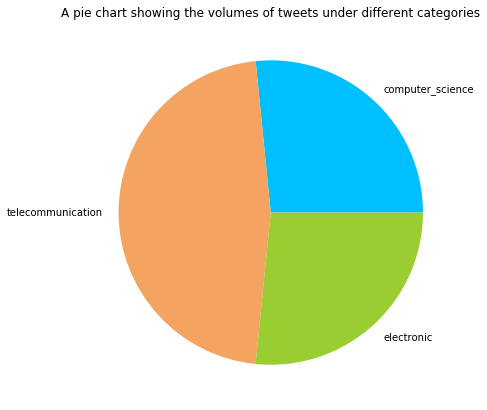

In [44]:
fig = plt.figure(figsize =(10, 7)) 
a = pivot_clusters.drop(['total'], axis = 1)
colors_list=['deepskyblue', 'sandybrown', 'yellowgreen']
plt.pie(a.loc['Total'], labels = a.columns, colors = colors_list)
plt.title('A pie chart showing the volumes of tweets under different categories')
plt.show() 

#### Bar plot showing users with most tweets

Text(0, 0.5, 'total tweets')

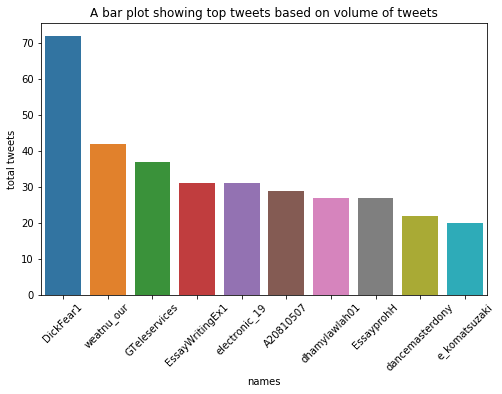

In [45]:
d = pivot_clusters.sort_values(by = 'total', ascending  = False)
e = d.head(12)
e.drop(e.head(2).index, inplace=True)
plt.figure(figsize=(8,5))
sns.barplot(x = e.index, y = e.total)
plt.title('A bar plot showing top tweets based on volume of tweets')
plt.xticks(rotation=45)
plt.xlabel('names')
plt.ylabel('total tweets')

## Distribution 

In [46]:
# drop the totals row
print(pivot_clusters.shape)
pivot_clusters.drop(pivot_clusters.tail(1).index,inplace=True)
print(pivot_clusters.shape)

(9134, 4)
(9133, 4)


#### 1. Distribution per category

(0, 10)

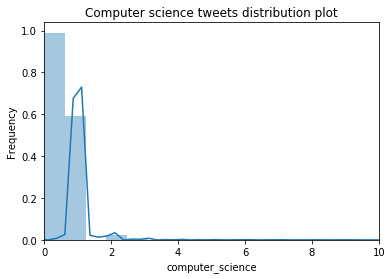

In [47]:
sns.distplot(pivot_clusters['computer_science']);
plt.title('Computer science tweets distribution plot')
plt.ylabel('Frequency')
plt.xlim(0, 10)

(0, 10)

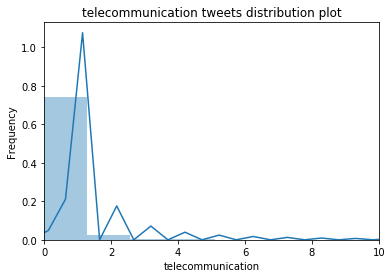

In [48]:
sns.distplot(pivot_clusters['telecommunication']);
plt.title('telecommunication tweets distribution plot')
plt.ylabel('Frequency')
plt.xlim(0, 10)

(0, 10)

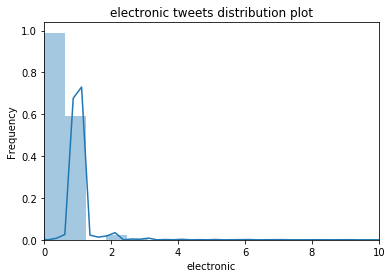

In [49]:
sns.distplot(pivot_clusters['electronic']);
plt.title('electronic tweets distribution plot')
plt.ylabel('Frequency')
plt.xlim(0, 10)

#### 2. Teleinformatics (telecommunication & computer science)

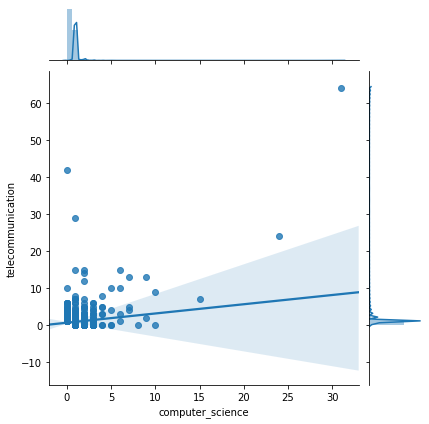

In [50]:
sns.jointplot(x ='computer_science', y ='telecommunication', data = pivot_clusters, kind="reg") 

#### 3. IoT (electronic & automation)

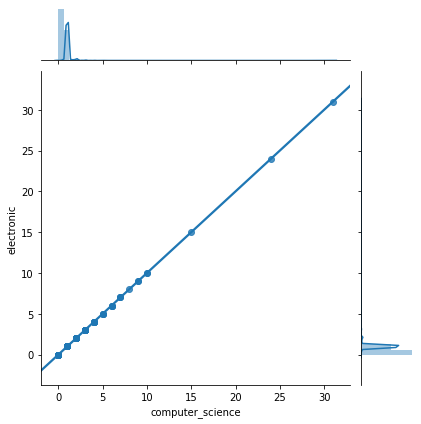

In [51]:
sns.jointplot(x ='computer_science', y ='electronic', data = pivot_clusters, kind ='reg') 

##  K-Means clustering

* The K-Means algorithm needs no introduction. It is simple and perhaps the most commonly used algorithm for clustering.
* The Elbow Method is probably the most well-known method for determining the optimal number of clusters. 
* Calculate the Within-Cluster-Sum of Squared Errors (WCSS) for different values of k, and choose the k for which WCSS becomes first starts to diminish. In the plot of WSS-versus-k, this is visible as an elbow.

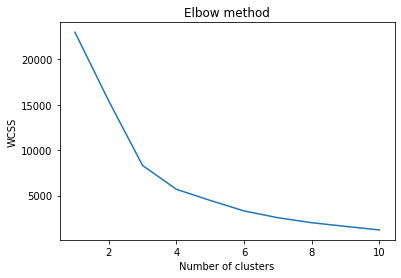

In [54]:
X = pivot_clusters[['computer_science', 'telecommunication','electronic']].values
# elbow Method
from sklearn.cluster import KMeans
wcss = []
for k in range(1, 11):
    # building and fitting the model 
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

> The plot looks like an arm with a clear elbow at k = 4.

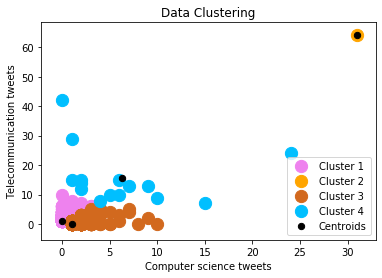

In [55]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)
# Visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=150, c='violet', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=150, c='orange', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=150, c='chocolate', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=150, c='deepskyblue', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=40, c='black', label='Centroids' )
plt.title('Data Clustering')
plt.xlabel('Computer science tweets')
plt.ylabel('Telecommunication tweets')
plt.legend()
plt.show()

### 2D clusters

#### 1. Teleinformatics (telecommunication & computer science)

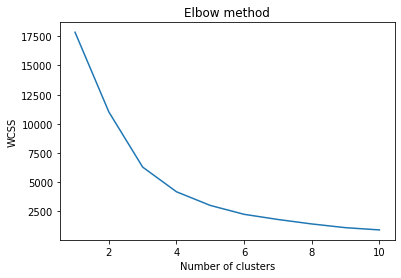

In [56]:
X = pivot_clusters[['computer_science', 'telecommunication']].values
# elbow Method
from sklearn.cluster import KMeans
wcss = []
for k in range(1, 11):
    # building and fitting the model 
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

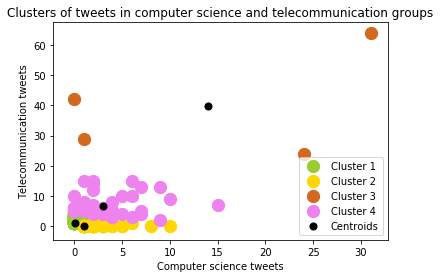

In [57]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)
# visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=150, c='yellowgreen', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=150, c='gold', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=150, c='chocolate', label= 'Cluster 3')
plt.scatter(X[Y_kmeans==3, 0], X[Y_kmeans==3, 1], s=150, c='violet', label= 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black', label='Centroids' )
plt.title('Clusters of tweets in computer science and telecommunication groups')
plt.xlabel('Computer science tweets')
plt.ylabel('Telecommunication tweets')
plt.legend()
plt.show()

#### 2. IoT (electronic & automation)

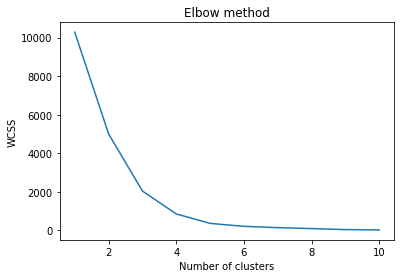

In [58]:
X = pivot_clusters[['computer_science', 'electronic']].values
# elbow Method
from sklearn.cluster import KMeans
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11), wcss)
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

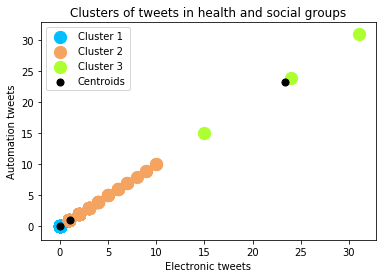

In [59]:
# fitting kmeans to dataset
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=0)
Y_kmeans = kmeans.fit_predict(X)
# visualising the clusters
plt.scatter(X[Y_kmeans==0, 0], X[Y_kmeans==0, 1], s=150, c='deepskyblue', label= 'Cluster 1')
plt.scatter(X[Y_kmeans==1, 0], X[Y_kmeans==1, 1], s=150, c='sandybrown', label= 'Cluster 2')
plt.scatter(X[Y_kmeans==2, 0], X[Y_kmeans==2, 1], s=150, c='greenyellow', label= 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=50, c='black', label='Centroids' )
plt.title('Clusters of tweets in health and social groups')
plt.xlabel('Electronic tweets')
plt.ylabel('Automation tweets')
plt.legend()
plt.show()

###  KMeans clustering with PCA

* To make the clustering more apparent, we can use the K-means algorithm with PCA.
* PCA (Principal Components Analysis) reduces the number of features in our data set. By reducing the number of features, we’re improving the performance of our algorithm.

In [60]:
# needed import for dimension reduction
from sklearn.decomposition import PCA

In [61]:
# first, we must fit our standardized data using PCA
seg = pivot_clusters.copy()
pca = PCA()
pca.fit(seg)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [62]:
# Second, we need to decide how many features we’d like to keep based on the cumulative variance plot
pca.explained_variance_ratio_

array([8.38918129e-01, 1.61081871e-01, 3.61556186e-31, 1.43799397e-34])

Text(0, 0.5, 'Cummulative explained variance')

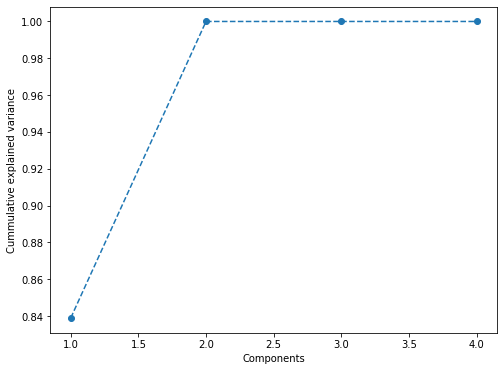

In [63]:
plt.figure(figsize = (8,6))
plt.plot(range(1,5), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('Components')
plt.ylabel('Cummulative explained variance')

> The graph shows the amount of variance captured (on the y-axis) depending on the number of components we include (the x-axis). A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 2 components.

In [64]:
pca = PCA(n_components = 2)
pca.fit(seg)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [65]:
pca.transform(seg)

array([[-0.65022288,  0.60804491],
       [ 0.36270405, -1.11647794],
       [ 0.36270405, -1.11647794],
       ...,
       [-0.65022288,  0.60804491],
       [-0.65022288,  0.60804491],
       [-0.65022288,  0.60804491]])

In [66]:
scores = pca.transform(seg)

Text(0, 0.5, 'WCSS')

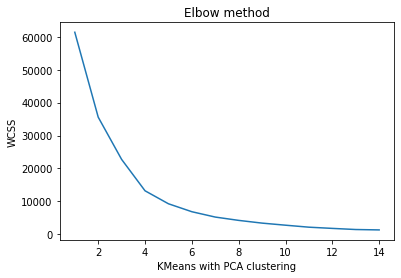

In [67]:
# elbow Method
from sklearn.cluster import KMeans
wcss = []
# creating 15 K-Means models while varying the number of clusters (k)
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
     # fit model to samples
    kmeans.fit(scores)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,15), wcss)
plt.title('Elbow method')
plt.xlabel('KMeans with PCA clustering')
plt.ylabel('WCSS')

In [68]:
n = 4
kmeans_pca = KMeans(n_clusters = n, init = 'k-means++', random_state = 0)
kmeans_pca.fit(scores)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [69]:
c = pd.concat([seg.reset_index(drop = True), pd.DataFrame(scores)], axis = 1)
c.columns.values[-2:] = ['component1', 'component2']
c['segment_kmeans_pca'] = kmeans_pca.labels_

Text(0.5, 1.0, 'Clusters by PCA')

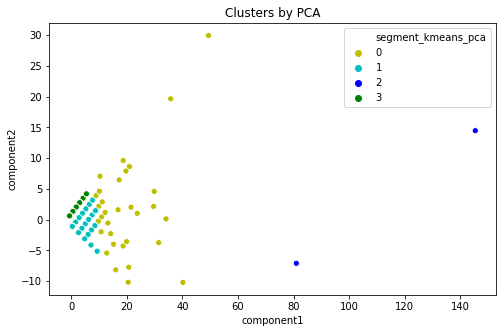

In [72]:
plt.figure(figsize = (8,5))
sns.scatterplot(x = c['component1'], y = c['component2'], hue = c['segment_kmeans_pca'], palette = ['y','c','b','g'])
plt.title('Clusters by PCA')